In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

**Načti data kromě Prahy-Ruzyně ještě z meteostanice Lysá Hora a:**

0. Pomocí grafu porovnej vývoj ročního úhrnu srážek v jednotlivých stanicích

In [4]:
def read_data(excel_data: pd.io.excel._base.ExcelFile, sheet_name: str):
    return excel_data.parse(sheet_name, skiprows=3)

In [5]:
def tidy_data(data: pd.DataFrame, sheet_name: str):
    return data.melt(id_vars=["rok", "měsíc"], var_name="den", value_name=sheet_name).dropna()

In [6]:
def create_time_frame(data_tidy: pd.DataFrame):
    return pd.to_datetime(data_tidy[["rok", "měsíc", "den"]].rename(
    columns={"rok": "year", "měsíc": "month", "den": "day"}
    ))

In [7]:
def index_and_sort_by_date(data_tidy: pd.DataFrame, datum: pd.Series):
    return (
        data_tidy.assign(datum=datum)
        .set_index("datum")
        .drop(columns=["rok", "měsíc", "den"])
        .sort_index()
    )

In [8]:
def extract_and_clean_chmi_excel_sheet(
    excel_data: pd.io.excel._base.ExcelFile, 
    sheet_name: str):
    
    data = read_data(excel_data, sheet_name)
    data_tidy = tidy_data(data, sheet_name)
    date = create_time_frame(data_tidy)
    return index_and_sort_by_date(data_tidy, date)

In [9]:
excel_data_ruzyne = pd.ExcelFile("P1PRUZ01.xls")
extracted_sheets = (
    extract_and_clean_chmi_excel_sheet(excel_data_ruzyne, sheet_name)
    for sheet_name in excel_data_ruzyne.sheet_names[1:]
)
ruzyne_tidy = pd.concat(extracted_sheets, axis=1)

In [10]:
excel_data_ruzyne = pd.ExcelFile("O1LYSA01.xls")
extracted_sheets = (
    extract_and_clean_chmi_excel_sheet(excel_data_ruzyne, sheet_name)
    for sheet_name in excel_data_ruzyne.sheet_names[1:]
)
lysa_hora_tidy = pd.concat(extracted_sheets, axis=1)

In [13]:
def compare_data_for_timeperiod_daily(
    column_name: str, 
    year_since: int, month_since: int, day_since: int,
    year_till: int, month_till: int, day_till: int
):
    # year = pd.Series(ruzyne_tidy.index.year)
    #http://blog.adnansiddiqi.me/data-visualization-in-python-line-graph-in-matplotlib/
    ruzyne_precipitation = ruzyne_tidy.loc[
        pd.Timestamp(year_since, month_since, day_since) : pd.Timestamp(year_till, month_till, day_till)
    ][column_name]
    lysa_hora_precipitation = lysa_hora_tidy[
        pd.Timestamp(year_since, month_since, day_since) : pd.Timestamp(year_till, month_till, day_till)
    ][column_name]

    plt.plot(lysa_hora_precipitation, color='orange', label="Lysa Hora")
    plt.plot(ruzyne_precipitation, color='g', label='Ruzyne')
    plt.xlabel('Date')
    plt.ylabel('Precipitation')
    plt.title('Precipitation development in Ruzyne and Lysa Hora')
    plt.legend()

    plt.show()

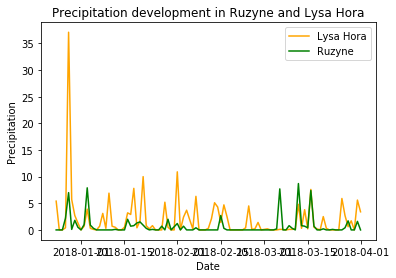

In [14]:
compare_data_for_timeperiod_daily("úhrn srážek", 2017, 12, 24, 2018, 4, 1)

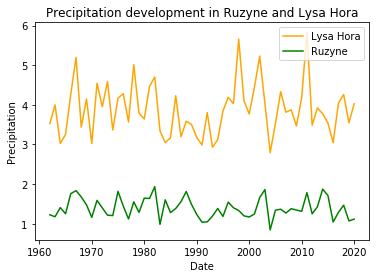

In [15]:
# VARIANTA 2:
ruzyne_yearly = ruzyne_tidy.resample("1Y")
lysa_hora_yearly = lysa_hora_tidy.resample("1Y")
plt.plot(lysa_hora_yearly["úhrn srážek"].mean(), color='orange', label="Lysa Hora")
plt.plot(ruzyne_yearly["úhrn srážek"].mean(), color='g', label='Ruzyne')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation development in Ruzyne and Lysa Hora')
plt.legend()

1.Zjisti, ve které z těchto stanic byl nejteplejší den v roce 2010 a který to byl.

In [17]:
def find_max_day_for_station(station: pd.DataFrame):
    
    return station.loc[
        (station["teplota průměrná"] == station.loc[station.index.year == 2010]["teplota průměrná"].max())
        & (station.index.year == 2010),
    ]

In [18]:
def find_hottes_day():
    ruzyne = find_max_day_for_station(ruzyne_tidy)
    lysa_hora = find_max_day_for_station(lysa_hora_tidy)
    if ruzyne["teplota maximální"][0] > lysa_hora["teplota maximální"][0]:
        return ruzyne, "ruzyne"
    else: 
        return lysa_hora, "lysa"

In [19]:
find_hottes_day()

(            teplota průměrná  teplota maximální  teplota minimální  \
 datum                                                                
 2010-07-12              27.4               33.8               18.2   
 
             rychlost větru  tlak vzduchu  vlhkost vzduchu  úhrn srážek  \
 datum                                                                    
 2010-07-12             2.3         971.6             45.0          2.0   
 
             celková výška sněhu  sluneční svit  
 datum                                           
 2010-07-12                  0.0           15.0  ,
 'ruzyne')

2. Zjisti, kde bylo (v průměru) nejteplejších 90 % dní v roce 2018 a kde nejstudenějších 10 %.

In [20]:
ruzyne_90_max = ruzyne_tidy.loc[
    (ruzyne_tidy.index.year == 2018)
    & (ruzyne_tidy["teplota průměrná"] > ruzyne_tidy["teplota průměrná"].quantile(0.10))
]["teplota průměrná"].mean()

lysa_90_max = lysa_hora_tidy.loc[
    (lysa_hora_tidy.index.year == 2018)
    & (lysa_hora_tidy["teplota průměrná"] > lysa_hora_tidy["teplota průměrná"].quantile(0.10))
]["teplota průměrná"].mean()

ruzyne_90_min = ruzyne_tidy.loc[
    (ruzyne_tidy.index.year == 2018)
    & (ruzyne_tidy["teplota průměrná"] < ruzyne_tidy["teplota průměrná"].quantile(0.10))
]["teplota průměrná"].mean()

lysa_90_min = lysa_hora_tidy.loc[
    (lysa_hora_tidy.index.year == 2018)
    & (lysa_hora_tidy["teplota průměrná"] < lysa_hora_tidy["teplota průměrná"].quantile(0.10))
]["teplota průměrná"].mean()

print(ruzyne_90_max, ruzyne_90_min, lysa_90_max, lysa_90_min)


12.004776119402985 -4.889285714285714 6.670731707317073 -10.837142857142858


3. Porovnej průměrný denní svit v 90. letech (1990 - 1999) v Praze a na Lysé Hoře.

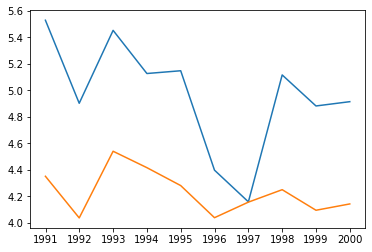

In [21]:
plt.plot(ruzyne_tidy.loc[(ruzyne_tidy.index.year < 2000) & (ruzyne_tidy.index.year > 1989)].resample("1Y")["sluneční svit"].mean())
plt.plot(lysa_hora_tidy.loc[(lysa_hora_tidy.index.year < 2000) & (lysa_hora_tidy.index.year > 1989)].resample("1Y")["sluneční svit"].mean())

4. Načti data z https://data4pydata.s3-eu-west-1.amazonaws.com/pyladies/P1PRUZ01schibami.xls, kde jsou chybějící data označena jako #CHYBA MĚŘENÍ.

Pomocí volby na_values při načítání dat z Excel souboru správně označ chyby měření jako chybějící data.
Odstraň pouze řádky, kde je špatné datum (tip: použij dropna(subset=)). Pomocí fillna pak nahraď chybějící měření poslední předchozí hodnotou.

In [22]:
DATA_FILENAME = "P1PRUZ01schybami.xls"
DATA_URL = "https://data4pydata.s3-eu-west-1.amazonaws.com/pyladies/P1PRUZ01schibami.xls"

In [23]:
import os
import urllib.request

def save_file_from_url(url, target_filename):
    if not os.path.isfile(target_filename):
        print("Stahuji data - počkej chvíli ...")
        urllib.request.urlretrieve(url, target_filename)
    print(f"Data jsou v souboru {target_filename}")

In [24]:
save_file_from_url(DATA_URL, DATA_FILENAME)

Data jsou v souboru P1PRUZ01schybami.xls


In [25]:
def extract_and_clean_chmi_excel_sheet(excel_data, sheet_name):
    data_tidy = (
        excel_data.parse(sheet_name, skiprows=3, na_values="#CHYBA MĚŘENÍ")
        .melt(id_vars=["rok", "měsíc"], var_name="den", value_name=sheet_name)
    )
    datum = pd.to_datetime(
    data_tidy[["rok", "měsíc", "den"]].rename(
        columns={"rok": "year", "měsíc": "month", "den": "day"}
    ),
    errors="coerce",)
    data_tidy.dropna(subset=["rok", "měsíc", "den"])

    data_tidy[sheet_name] = data_tidy[sheet_name].fillna(method = 'ffill')

    return (
        data_tidy.assign(datum=datum)
        .set_index("datum")
        .drop(columns=["rok", "měsíc", "den"])
        .sort_index()
    )

In [26]:
excel_data_ruzyne_s_chybami = pd.ExcelFile("P1PRUZ01schybami.xls")
extracted_sheets = (
    extract_and_clean_chmi_excel_sheet(excel_data_ruzyne_s_chybami, sheet_name)
    for sheet_name in excel_data_ruzyne_s_chybami.sheet_names[1:]
)
ruzyne_s_chybami = pd.concat(extracted_sheets, axis=1)

In [27]:
ruzyne_s_chybami

,teplota průměrná,teplota maximální,teplota minimální,rychlost větru,tlak vzduchu,vlhkost vzduchu,úhrn srážek,celková výška sněhu,sluneční svit
datum,,,,,,,,,
1961-01-01,-2.0,1.0,-3.4,1.7,969.9,87.0,0.0,6.0,0.4
1961-01-02,-1.9,-1.2,-2.4,3.0,965.2,89.0,0.0,4.0,0.0
1961-01-03,0.1,1.0,-2.6,2.7,952.3,80.0,0.0,3.0,0.0
1961-01-04,-0.3,2.1,-2.0,3.3,953.6,87.0,0.0,3.0,1.0
1961-01-05,0.4,2.8,-4.3,6.3,963.9,81.0,0.0,2.0,2.2
...,...,...,...,...,...,...,...,...,...
NaT,6.0,9.2,-1.3,5.7,968.1,73.0,0.6,0.0,2.3
NaT,5.6,8.4,2.4,3.3,954.6,88.0,1.6,0.0,0.1
NaT,23.6,29.0,12.6,2.7,972.7,52.0,0.0,0.0,12.3


In [28]:
ruzyne_s_chybami.to_excel("ruzyne_s_chybami.xlsx")

5. Jak často přijíždí Svatý Martin na bílém koni? Jaké je procento svátků Sv. Martina (11. 11.), kdy byla celková výška sněhu větší než 0?

In [29]:
len(ruzyne_tidy.loc[(ruzyne_tidy.index.day == 11) 
                & (ruzyne_tidy.index.month == 11)
                & (ruzyne_tidy["celková výška sněhu"] > 0)
               ].index) / len(ruzyne_tidy.index)

0.00018562346280569865

6. Který z ledových mužů je nejmrazivější? Pankrác (12. 5.), Servác (13. 5.) nebo Bonifác (14. 5.)? Zjisti to porovnáním procent těchto dní s minimální teplotou < 0. Pokud budou procenta vyrovnaná, vyhraje den s nižší průměrnou teplotou.

In [115]:
def find_average_lowest_temp_table(day: int, month: int):
    return ruzyne_tidy.loc[(ruzyne_tidy.index.day == day) 
                & (ruzyne_tidy.index.month == month)
                & (ruzyne_tidy["teplota minimální"] <= 0)]

In [125]:
def find_coldest_day(datumy):
    ice_men = (
        find_average_lowest_temp_table(int(date.split(".")[0]), int(date.split(".")[1]))
        for date in datumy
    )

    ice_men_extracted = pd.concat(ice_men)
    if ice_men_extracted["teplota minimální"].mean() < 1:
        return ice_men_extracted.loc[ice_men_extracted["teplota průměrná"] == ice_men_extracted["teplota průměrná"].min()]

In [126]:
find_coldest_day(["12.5", "13.5", "14.5"])

,teplota průměrná,teplota maximální,teplota minimální,rychlost větru,tlak vzduchu,vlhkost vzduchu,úhrn srážek,celková výška sněhu,sluneční svit
datum,,,,,,,,,
1978-05-12,4.6,9.5,0.0,5.3,968.4,64.0,4.1,0.0,4.1
